# <font color = blue>[Model Selection + Refinement ]</font>

## <font color = blue>Import Packages + Data</font>

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas_profiling as prof
import missingno as msno
import datetime as dt
import os
%matplotlib inline

In [172]:
ml_df =pd.read_csv("./Prepared_Data/ml_df.csv")

In [173]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             10324 non-null  object 
 1   managed_by                          10324 non-null  object 
 2   fulfill_via                         10324 non-null  object 
 3   vendor_inco_term                    10324 non-null  object 
 4   shipment_mode                       10324 non-null  object 
 5   product_group                       10324 non-null  object 
 6   sub_classification                  10324 non-null  object 
 7   vendor                              10324 non-null  object 
 8   brand                               10324 non-null  object 
 9   dosage_form                         10324 non-null  object 
 10  unit_of_measure_per_pack            10324 non-null  int64  
 11  line_item_quantity                  10324

In [174]:
ml_df.head()

,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,product_group,sub_classification,vendor,brand,dosage_form,...,manufacturing_site_quantitycount,manufacturing_site_valuecount,manufacturing_site_usdcount,manufacturing_site_calculatedcount,vendor_quantitycount,vendor_valuecount,vendor_usdcount,vendor_calculatedcount,molecule_test_type_valuemean,molecule_test_type_calculatedmean
0,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,Reveal,Test kit,...,2,2,2,2,2,2,2,2,551.000000,13.000000
1,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,Reveal,Test kit,...,2,2,2,2,2,2,2,2,551.000000,13.000000
2,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,Generic,Oral suspension,...,25,25,25,25,25,25,25,25,59850.446667,1512.344067
3,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,Generic,Capsule,...,25,25,25,25,25,25,25,25,59850.446667,1512.344067
4,Nigeria,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,Generic,Oral solution,...,25,25,25,25,25,25,25,25,59850.446667,1512.344067


## <font color = blue>Build Data Pipeline</font>

In [175]:
from sklearn.preprocessing import FunctionTransformer,PolynomialFeatures, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer ,StandardScaler
from sklearn.pipeline import TransformerMixin, _BaseComposition 
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection
from sklearn.metrics import classification_report, mean_squared_error,accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import category_encoders as ce
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import  BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor


from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.utils import class_weight
import warnings; warnings.simplefilter('ignore')
from yellowbrick.classifier import ClassificationReport

In [176]:
#Encode the Categorical variables
OHE = ce.OneHotEncoder(cols=['country','managed_by','fulfill_via','vendor_inco_term','shipment_mode','product_group','sub_classification',
                             'vendor','brand','dosage_form','first_line_designation','dosage','weight_captured_seperately','freight_invoiced_seperately',
                      'freight_in_commodity_cost','origin_country','origin_continent'],use_cat_names=True)
# encode the categorical variables
df1 = OHE.fit_transform(ml_df)

In [177]:
# Scale the continuous data
pipe = make_pipeline(StandardScaler())
pipe.fit(df1[['delivery_delay_time','line_item_quantity','weight_calculated','freight_cost_calculated','line_item_value',
                   'scheduled_delivery_date_y','scheduled_delivery_date_m','scheduled_delivery_date_d','fsi','customs',
                    'infra','intl_ship','timeliness','track_trace','origin_fsi','origin_customs','origin_infra','origin_intl_ship','origin_logistic_qlty','origin_lpi','origin_timeliness','origin_track_trace',
             'scheduled_delivery_date_weekday','scheduled_delivery_date_weekofyear','scheduled_delivery_date_quarter'
                     ,'scheduled_delivery_date_y','scheduled_delivery_date_m','scheduled_delivery_date_d',
 'brand_valuemean', 'brand_quantitymean', 'brand_calculatedmean',
 'country_valuemean', 'country_usdmean', 'country_quantitymean',
 'manufacturing_site_quantitycount', 'manufacturing_site_valuecount', 'manufacturing_site_calculatedcount', 'manufacturing_site_usdcount',
 'vendor_quantitycount', 'vendor_valuecount', 'vendor_usdcount', 'vendor_calculatedcount',
 'molecule_test_type_calculatedmean', 'molecule_test_type_valuemean' ]])

Pipeline(steps=[('standardscaler', StandardScaler())])

In [168]:
#Build Model

# separate the independent and target variable 
train_X = df1.drop(columns=['delayed','delivery_delay_time'])

train_Y = df1['delayed']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=42)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

#SMOTE for imbalanced data
sm = SMOTE(random_state=42)
train_x_sm, train_y_sm = sm.fit_resample(train_x, train_y)
print('After OverSampling, the shape of train_X: {}'.format(train_x_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(train_y_sm.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(train_y_sm == True)))
print("After OverSampling, counts of label '0': {}".format(sum(train_y_sm == False)))


After OverSampling, the shape of train_X: (13728, 342)
After OverSampling, the shape of train_y: (13728,) 

After OverSampling, counts of label '1': 6864
After OverSampling, counts of label '0': 6864


## <font color = blue>Benchmark for Classification Model</font>

- ## <font color = blue>Random Forest Model</font>

In [116]:
# create an object of the RandomForestclassifier
model_RFC = RandomForestClassifier(n_estimators = 100)

# fit the model with the training data
model_RFC.fit(train_x_sm, train_y_sm)

# performing predictions on the test dataset
y_pred = model_RFC.predict(test_x)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_y, y_pred))

ACCURACY OF THE MODEL:  0.8853157690817512


<AxesSubplot:>

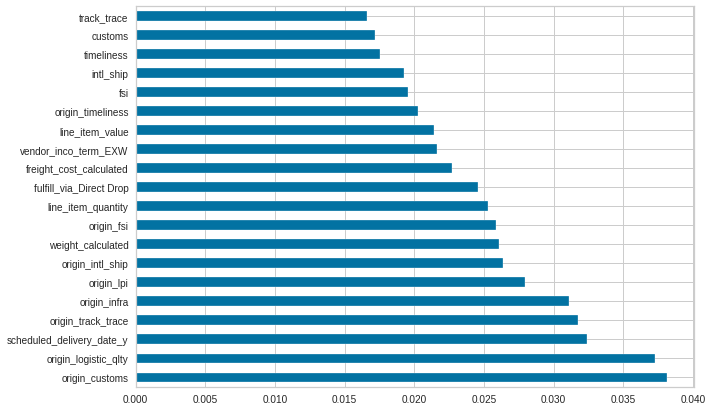

In [117]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFC.feature_importances_, index = train_x_sm.columns)
feat_importances.nlargest(20).plot(kind='barh')

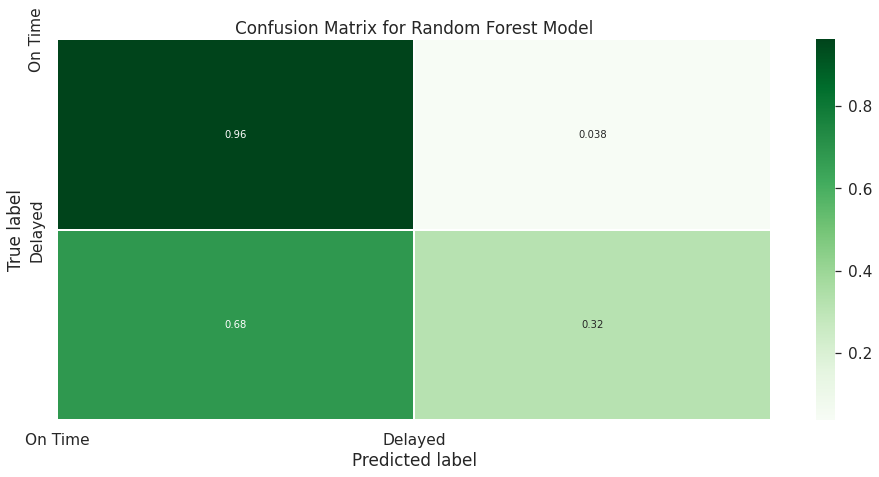

In [118]:
#Confusion Matrix
confusion_matrix(test_y, y_pred)

# Get and reshape confusion matrix data
matrix = confusion_matrix(test_y, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['On Time', 'Delayed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [119]:
print('Precision: %.3f' % precision_score(test_y, y_pred))
print('Recall: %.3f' % recall_score(test_y, y_pred))
print('Accuracy: %.3f' % accuracy_score(test_y, y_pred))
print('F1 Score: %.3f' % f1_score(test_y, y_pred))

Precision: 0.530
Recall: 0.319
Accuracy: 0.885
F1 Score: 0.398


## <font color = blue>Select Classification Model</font>

In [178]:
def model_selection(X_train, X_test, y_train, y_test, estimator, alg_type):

    # Scoring functions and some estimator built in container
    from sklearn.metrics import f1_score, r2_score, mean_squared_error
    from sklearn.pipeline import Pipeline#, preprocessing
    from sklearn import preprocessing
    import numpy as np

    model = Pipeline([('estimator', estimator)])    
    if alg_type == 'clf':
        model.fit(X_train, y_train)
        expected  = y_test
        predicted = model.predict(X_test)
        # Compute and return the F1 score (the harmonic mean of precision and recall)
        return (f1_score(expected, predicted))
    elif alg_type == 'reg':
        model.fit(X_train, y_train)
        expected  = y_test
        predicted = model.predict(X_test)
        # Compute and return the R2 and RMSE metrics
        r = (r2_score(expected, predicted), np.sqrt(mean_squared_error(expected, predicted)))
        return r

<AxesSubplot:title={'center':'F1 Score Comparison for Classifiers'}>

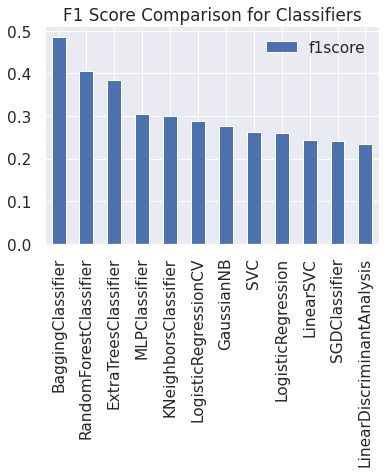

In [121]:
# List of classifiers
clfs = [LinearSVC, SVC, KNeighborsClassifier, LogisticRegressionCV, LogisticRegression, SGDClassifier
,BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, MLPClassifier
       ,GaussianNB, LinearDiscriminantAnalysis]
# List of classiffier names
cn = ['LinearSVC' , 'SVC', 'KNeighborsClassifier', 'LogisticRegressionCV', 'LogisticRegression', 'SGDClassifier'
,'BaggingClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'MLPClassifier'
      , 'GaussianNB', 'LinearDiscriminantAnalysis']   
# Plot the f1 scores
acc = []
for clf in clfs:
    try:
        acc.append(model_selection(train_x_sm, test_x, train_y_sm, test_y, clf(), 'clf'))
    except:
        acc.append(0)
d_acc = pd.DataFrame(acc, cn)
d_acc.columns = ["f1score"]
d_acc.sort_values(by ='f1score',ascending=False).plot(kind="bar", title="F1 Score Comparison for Classifiers")

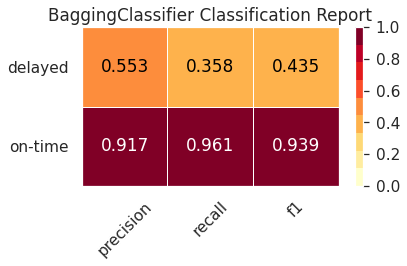

<AxesSubplot:title={'center':'BaggingClassifier Classification Report'}>

In [141]:
model = BaggingClassifier()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

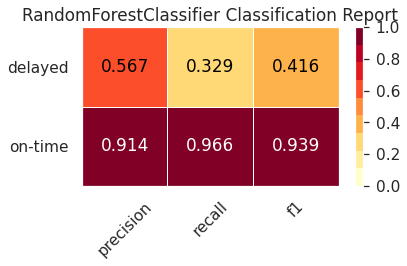

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [136]:
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

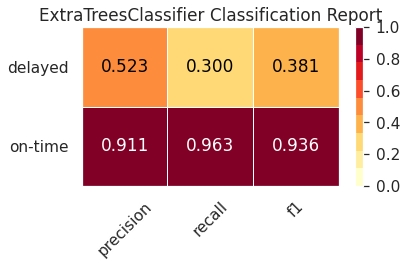

<AxesSubplot:title={'center':'ExtraTreesClassifier Classification Report'}>

In [135]:
model = ExtraTreesClassifier()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

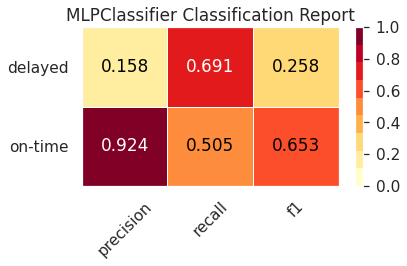

<AxesSubplot:title={'center':'MLPClassifier Classification Report'}>

In [137]:
model = MLPClassifier()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

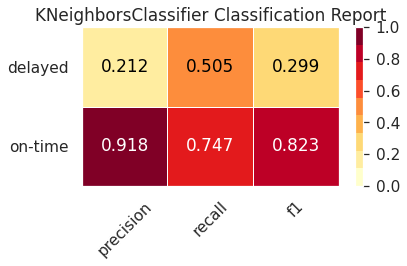

<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>

In [138]:
model = KNeighborsClassifier()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

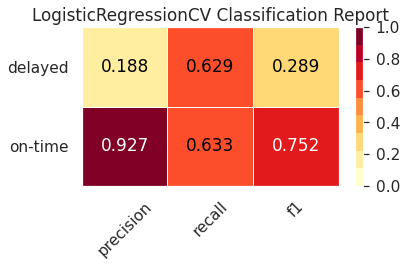

<AxesSubplot:title={'center':'LogisticRegressionCV Classification Report'}>

In [139]:
model = LogisticRegressionCV()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

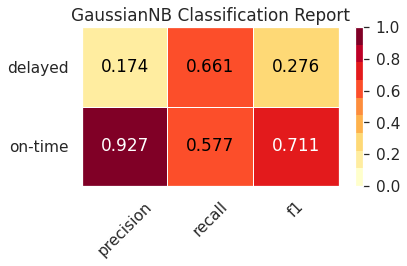

<AxesSubplot:title={'center':'GaussianNB Classification Report'}>

In [140]:
model = GaussianNB()
visualizer = ClassificationReport(model, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

### The scores show that the most suitable classifiers to predict the delay are BaggingClassifier, RandomForest and ExtraTreesClassifier 

## <font color = blue>Refine Final Models</font>

- ## <font color = blue>BaggingClassifier and  ExtraTreesRegressor</font>

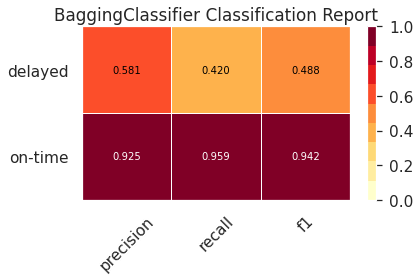

<AxesSubplot:title={'center':'BaggingClassifier Classification Report'}>

In [182]:
#Adjust Parameters
clf_final = BaggingClassifier(n_estimators=20,max_samples=1.0,max_features=1.0,bootstrap=True,bootstrap_features=False)
plt.subplots(figsize=(6,4))

visualizer = ClassificationReport(clf_final, classes=['on-time','delayed'])
visualizer.fit(train_x_sm, train_y_sm)
visualizer.score(test_x, test_y)
visualizer.show()

## <font color = blue>Benchmark for Regression Model</font>

- ## <font color = blue>Random Forest Model</font>

In [183]:
#Encode the Categorical variables
OHE = ce.OneHotEncoder(cols=['country','managed_by','fulfill_via','vendor_inco_term','shipment_mode','product_group','sub_classification',
                             'vendor','brand','dosage_form','first_line_designation','dosage','weight_captured_seperately','freight_invoiced_seperately',
                      'freight_in_commodity_cost','origin_country','origin_continent'],use_cat_names=True)
# encode the categorical variables
df1 = OHE.fit_transform(ml_df)

In [184]:
# Scale the continuous data
pipe = make_pipeline(StandardScaler())
pipe.fit(df1[['delivery_delay_time','line_item_quantity','weight_calculated','freight_cost_calculated','line_item_value',
                   'scheduled_delivery_date_y','scheduled_delivery_date_m','scheduled_delivery_date_d','fsi','customs',
                    'infra','intl_ship','timeliness','track_trace','origin_fsi','origin_customs','origin_infra','origin_intl_ship','origin_logistic_qlty','origin_lpi','origin_timeliness','origin_track_trace',
             'scheduled_delivery_date_weekday','scheduled_delivery_date_weekofyear','scheduled_delivery_date_quarter'
                     ,'scheduled_delivery_date_y','scheduled_delivery_date_m','scheduled_delivery_date_d',
 'brand_valuemean', 'brand_quantitymean', 'brand_calculatedmean',
 'country_valuemean', 'country_usdmean', 'country_quantitymean',
 'manufacturing_site_quantitycount', 'manufacturing_site_valuecount', 'manufacturing_site_calculatedcount', 'manufacturing_site_usdcount',
 'vendor_quantitycount', 'vendor_valuecount', 'vendor_usdcount', 'vendor_calculatedcount',
 'molecule_test_type_calculatedmean', 'molecule_test_type_valuemean' ]])

Pipeline(steps=[('standardscaler', StandardScaler())])

In [185]:
#Build Model

# separate the independent and target variable 
train_X = df1.drop(columns=['delayed','delivery_delay_time'])

train_Y = df1['delivery_delay_time']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=42)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((7743, 342), (2581, 342), (7743,), (2581,))

In [186]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10,random_state=2)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

print('R-squared on train data', metrics.r2_score(train_y, predict_train))
print('R-squared on test data', metrics.r2_score(test_y, predict_test))


RMSE on train data:  14.990838364232248
RMSE on test data:  19.74136094085739
R-squared on train data 0.6924966997496416
R-squared on test data 0.4964706021640035


<AxesSubplot:>

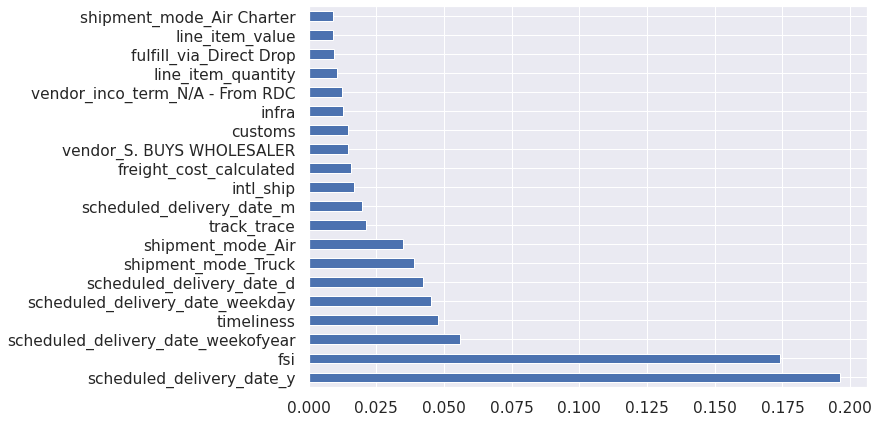

In [146]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [147]:
# Make dataframe of delayed vs. predicted
df_pred=pd.DataFrame(test_y, columns=['delayed']); df_pred['pred']= predict_test
print(df_pred.describe().T)


       count     mean        std    min      25%       50%       75%  \
pred  2581.0 -6.25732  18.217201 -220.0 -9.68583 -0.217086  0.075456   

             max  
pred  155.906663  


## <font color = blue>Select Regression Model</font>

<AxesSubplot:title={'center':'Root Mean Sqaured Error(RMSE)'}>

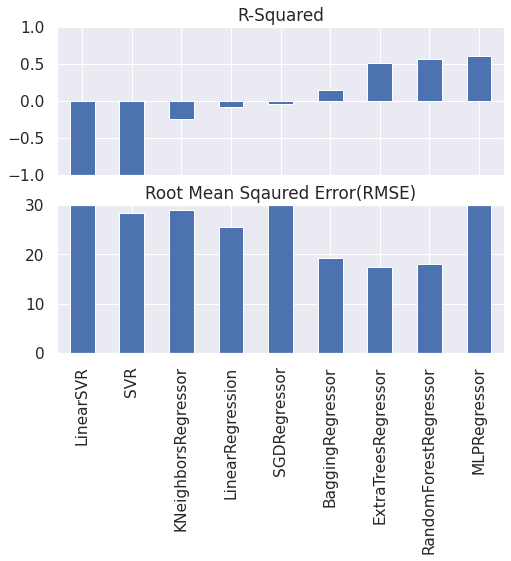

In [160]:
# List of regressors
regs = [LinearSVR, SVR, KNeighborsRegressor, LinearRegression , SGDRegressor,
        BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, MLPRegressor]
# List of regressor names
rn = ['LinearSVR', 'SVR', 'KNeighborsRegressor', 'LinearRegression', 'SGDRegressor',
    'BaggingRegressor', 'ExtraTreesRegressor', 'RandomForestRegressor', 'MLPRegressor']   
# Plot the f1 scores
rsq = []
for reg in regs:
    try:
        rsq.append(model_selection(train_x, test_x, train_y, test_y, reg(), 'reg'))
    except:
        rsq.append((0,0))
d_rsq = pd.DataFrame(rsq, rn, columns=['r2', 'rmse'])
f , (ax0,ax1) = plt.subplots(2,1, figsize=(8,6), sharex=True,)
d_rsq['r2'].sort_values().plot(kind="bar", ax=ax0, ylim=(-1,1), title="R-Squared")
d_rsq['rmse'].plot(kind="bar", ax=ax1, title="Root Mean Sqaured Error(RMSE)", ylim=(0,30))

### From the outcome of regression model, it shows that ExtraTreesRegressor and RandomForestRegressor have better performance than other models as their R-squared are high and RMSE are low.

## <font color = blue>Refine Final Models</font>

- ## <font color = blue>ExtraTreesRegressor</font>

In [188]:
reg_final = ExtraTreesRegressor(n_estimators=1000 ,max_features= 50,max_depth= 50)

rsq = []
rsq.append(model_selection(train_x, test_x, train_y, test_y, reg_final, 'reg'))
print("---\nR-Squared: ", rsq[0][0]," ---\nRMSE:", rsq[0][1])

---
R-Squared:  0.5547436606905345  ---
RMSE: 18.563921747364674
